In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler

In [2]:
#data = pd.read_csv("http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt", sep='|')

In [3]:
company = 'AMZN'
path = '/Users/prometheus/Downloads/archive/stocks/'

amazon = pd.read_csv(path+company+'.csv')

In [4]:
amazon

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5753,2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
5754,2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
5755,2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6126100
5756,2020-03-31,1964.349976,1993.020020,1944.010010,1949.719971,1949.719971,5123600


In [5]:
amazon.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5.758000e+03
mean,340.458153,344.156408,336.344390,340.417580,340.417580,7.556094e+06
std,523.365374,528.138556,517.726971,523.140207,523.140207,7.325904e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.460001,38.334999,36.812499,37.562500,37.562500,3.685525e+06
50%,81.965000,83.520000,79.875000,81.599998,81.599998,5.692450e+06
75%,335.267494,337.537491,331.727501,334.290001,334.290001,8.594350e+06
max,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,1.043292e+08


In [6]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5758 non-null   object 
 1   Open       5758 non-null   float64
 2   High       5758 non-null   float64
 3   Low        5758 non-null   float64
 4   Close      5758 non-null   float64
 5   Adj Close  5758 non-null   float64
 6   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 315.0+ KB


In [7]:
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon.set_index('Date', inplace=True)

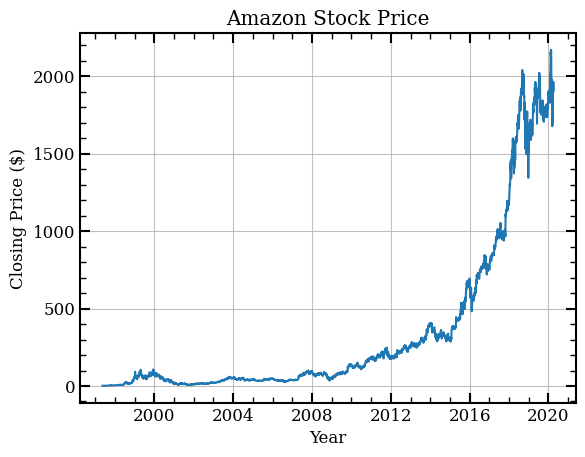

In [8]:
# plot
plt.plot(amazon['Close'])
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
plt.title('Amazon Stock Price')
plt.show()

In [9]:
amazon.index.max()

Timestamp('2020-04-01 00:00:00')

In [10]:
# can adjust date-times by: pd.Timestamp('2019-12-31') for instance
amazon = amazon.loc[amazon.index.min(): amazon.index.max()]

In [11]:
# calculate percentage change in stock
percent_change = amazon['Adj Close'].pct_change().fillna(0)

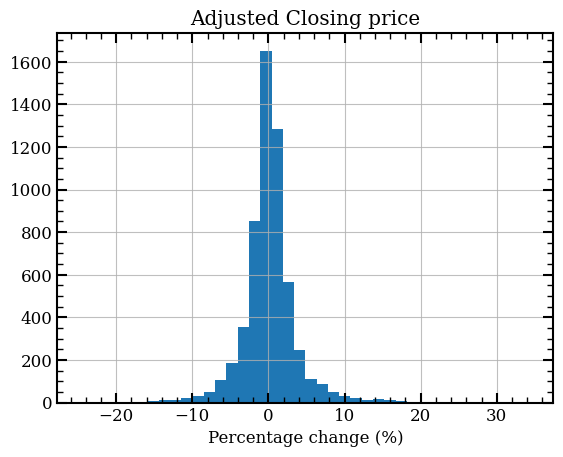

In [12]:
plt.hist(percent_change*100, bins = 40)
plt.title('Adjusted Closing price')
plt.xlabel('Percentage change (%)')
plt.show()

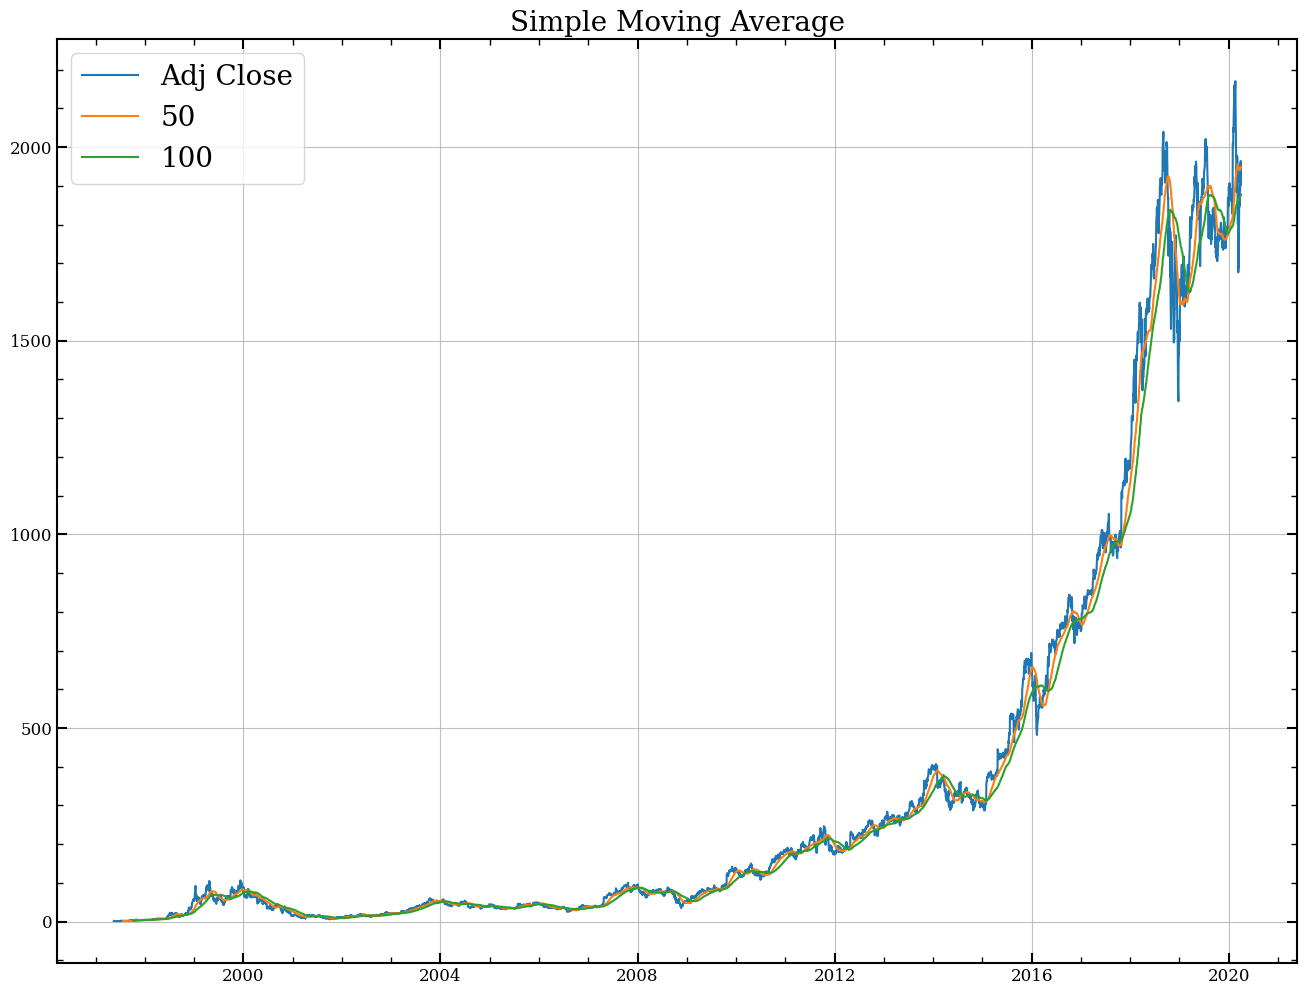

In [13]:
# look at moving average now

moving_avg_50 = amazon['Adj Close'].rolling(window=50).mean()
moving_avg_100 = amazon['Adj Close'].rolling(window=100).mean()

plt.figure(figsize=(16,12))
plt.plot(amazon['Adj Close'], label='Adj Close')
plt.plot(moving_avg_50, label='50')
plt.plot(moving_avg_100, label='100')
plt.title('Simple Moving Average', fontsize=20)
plt.legend(fontsize = 20)
plt.show()


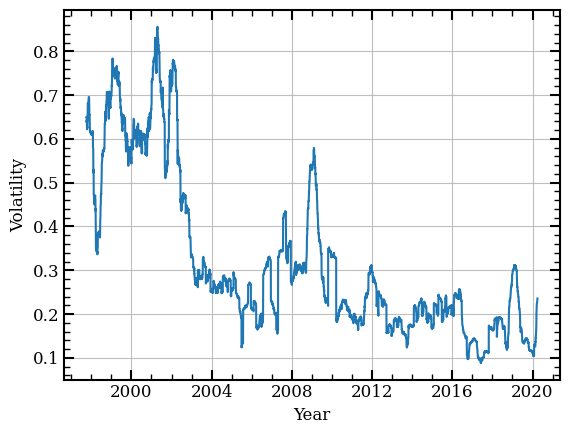

In [14]:
# look at volatility which is the change in variance of a stock's return over period of time.

# consider a period as above (50 or 100 days), volatility_period = sigma_period * sqrt(period)

window = 100
volatility = percent_change.rolling(window=window).std() * np.sqrt(window)

plt.plot(volatility) # can be log(volatility)
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.show()

 We need to now find the best short-term & long-term periods for crossover and the
 'golden-cross', where the short-term moving average rises above the long-term moving average.
 Long-term moving average has more weight to it and this crossover indicated a "BULL MARKET" is on the horizon, reinforced by high trading volumes.

 **Note:** A bull market is when assest prices have risen or are expected to rise

In [15]:
# use 13 and 49 day

# look at only the past 5 years
amzn_red = amazon.loc[pd.Timestamp('2014-12-31'): pd.Timestamp('2019-12-31')]

short = 13
long = 49

signals = pd.DataFrame(index=amazon.index)
signals['signal'] = 0.0

signals['short_ma'] = amzn_red['Close'].rolling(window=short, min_periods=1).mean()
signals['long_ma'] = amzn_red['Close'].rolling(window=long, min_periods=1).mean()
signals['signal'][short:] = np.where(signals['short_ma'][short:] 
                                     > signals['long_ma'][short:], 1.0, 0.0)   

signals['positions'] = signals['signal'].diff()


Text(0.5, 0, 'Year')

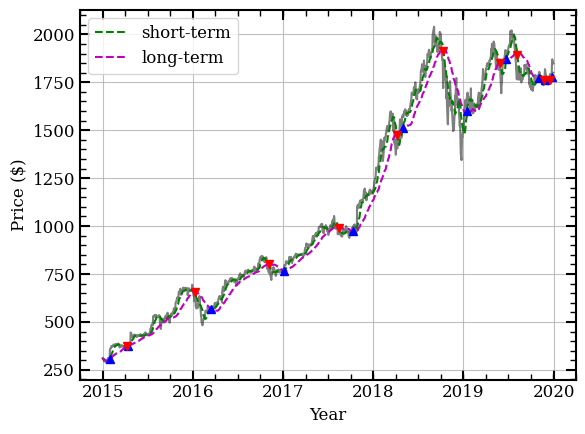

In [16]:
plt.plot(amzn_red['Close'], 'k-', alpha = 0.5)
plt.plot(signals['short_ma'], 'g--', label = 'short-term')
plt.plot(signals['long_ma'], 'm--', label = 'long-term')
plt.plot(signals.loc[signals.positions == 1].index,
         signals.short_ma[signals.positions == 1], 'b^')
plt.plot(signals.loc[signals.positions == -1].index,
         signals.short_ma[signals.positions == -1], 'rv')
plt.legend(loc = 0)
plt.ylabel('Price ($)')
plt.xlabel('Year')

Now let us make predictions

In [17]:
# scale
scaler = MinMaxScaler()
amazon_scaled = scaler.fit_transform(amazon.High.values.reshape(-1,1))
scaled_df = pd.DataFrame(amazon_scaled, columns=['High'])

In [18]:
#train, test = train_test_split(scaled_df)
train = scaled_df[:int(scaled_df.shape[0]*0.75)]
test = scaled_df[int(scaled_df.shape[0]*0.75):]

In [19]:
def create_timestep_data(df):
    if df.shape != (df.shape[0],1):
        print('reshaping data')
        df = df.reshape(-1,1)
        
    X,y = [], []
    for i in range(50, df.shape[0]):
        X.append(df[i-50:i,0])
        y.append(df[i,0])
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = np.array(y)
    return X, y

In [20]:
X_train, y_train = create_timestep_data(train.High.values)
X_test, y_test = create_timestep_data(test.High.values)

reshaping data
reshaping data


In [21]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.LSTM(units = 256 , return_sequences=True, input_shape=X_train.shape[1:]),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.LSTM(units=128, return_sequences=True),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(units=128, return_sequences=True),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(units=128),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Dense(1),
    ]
)

model.summary()

Metal device set to: Apple M1


2022-12-02 11:32:10.268766: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 11:32:10.268845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

In [22]:
# callbacks
earlystop = EarlyStopping(patience=25) 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=8, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
callbacks = [earlystop, learning_rate_reduction]

model.compile(optimizer='adam', loss = 'mse')

epochs=100 
history = model.fit(X_train, 
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=epochs,
                    callbacks=callbacks,
                   )

Epoch 1/100


2022-12-02 11:32:10.884604: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 11:32:13.043837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:13.332736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:13.459152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:13.544281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:13.626549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:13.764942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

134/134 [==============================] - ETA: 0s - loss: 1.6421e-04

2022-12-02 11:32:21.643262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:21.758672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:21.827161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:21.907828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:32:21.983767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 12s 67ms/step - loss: 1.6421e-04 - val_loss: 0.0131 - lr: 0.0010
Epoch 2/100
134/134 [==============================] - 7s 54ms/step - loss: 1.9323e-05 - val_loss: 0.0062 - lr: 0.0010
Epoch 3/100
134/134 [==============================] - 8s 57ms/step - loss: 2.1255e-05 - val_loss: 0.0040 - lr: 0.0010
Epoch 4/100
134/134 [==============================] - 7s 55ms/step - loss: 2.0337e-05 - val_loss: 0.0066 - lr: 0.0010
Epoch 5/100
134/134 [==============================] - 7s 56ms/step - loss: 1.6625e-05 - val_loss: 0.0073 - lr: 0.0010
Epoch 6/100
134/134 [==============================] - 7s 54ms/step - loss: 2.0794e-05 - val_loss: 0.0099 - lr: 0.0010
Epoch 7/100
134/134 [==============================] - 8s 56ms/step - loss: 1.7953e-05 - val_loss: 0.0055 - lr: 0.0010
Epoch 8/100
134/134 [==============================] - 8s 56ms/step - loss: 1.3964e-05 - val_loss: 0.0013 - lr: 0.0010
Epoch 9/100
134/134 [==============================] - 7s 5

Text(0.5, 0, 'Epoch')

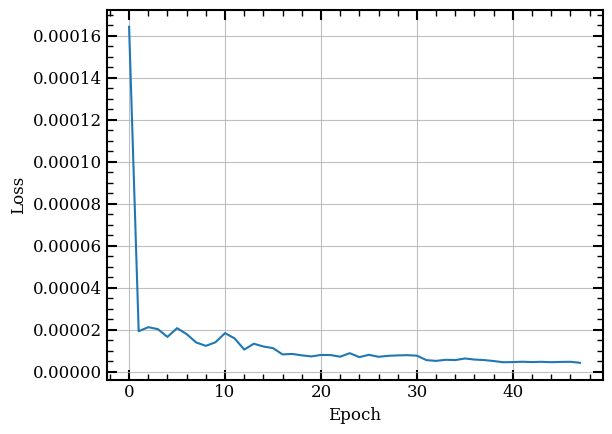

In [24]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [25]:
predictions = model.predict(X_test)

2022-12-02 11:38:12.380495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:38:12.498294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:38:12.570489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/44 [..............................] - ETA: 38s

2022-12-02 11:38:12.647738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-02 11:38:12.727839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 2s 27ms/step


In [26]:
y_pred = scaler.inverse_transform(predictions).reshape(1,-1)[0]

In [27]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [28]:
y_test = y_test.reshape(1,-1)[0]

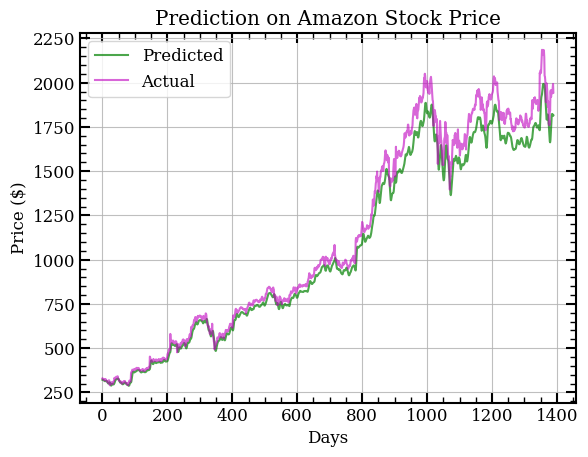

In [29]:
plt.plot(y_pred, 'g', alpha = 0.7, label = 'Predicted')
plt.plot(y_test, 'm', alpha = 0.6, label = 'Actual' )
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.title('Prediction on Amazon Stock Price')
plt.legend(loc=0)

In [30]:
# rough model accuracy
accuracy = np.sum(100 - 100*abs(y_test - y_pred)/ y_test) / y_test.shape[0]
print('Average accuracy: ', round(accuracy,2))

Average accuracy:  94.83
